In [35]:
# Import necessary libraries
import os
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from ultralytics import SAM
from ultralytics import YOLO
from itertools import groupby

DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.backends.cuda.is_available() else "cpu"
)
print(f"Using device: {DEVICE}")

Using device: mps


In [43]:
CLASS_NAMES = ['A1', 'A2', 'A3', 'B4', 'B5', 'C10', 'C11', 'C12', 'C6', 'C7', 'C8', 'C9', 'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
# Get a color palette that can handle many distinct colors (husl is good for many categories)
colors = sns.color_palette("bright", n_colors=len(class_names), as_cmap=False)
# Add alpha channel for transparency
CLASS_COLORS = [(r, g, b, 0.5) for r, g, b in colors]


In [3]:
# Load COCO segmentation train, test, and validation data from Data3

# Define the base path for the chosen dataset
data_path = "segmentation"

# Initialize paths for train, test, and validation data
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
val_path = os.path.join(data_path, "valid")

# Load annotations for each split
train_coco = COCO(os.path.join(train_path, "_annotations.coco.json"))
test_coco = COCO(os.path.join(test_path, "_annotations.coco.json"))
val_coco = COCO(os.path.join(val_path, "_annotations.coco.json"))

print(f"Loaded {len(train_coco.imgs)} training images")
print(f"Loaded {len(test_coco.imgs)} testing images")
print(f"Loaded {len(val_coco.imgs)} validation images")


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loaded 6722 training images
Loaded 959 testing images
Loaded 1921 validation images


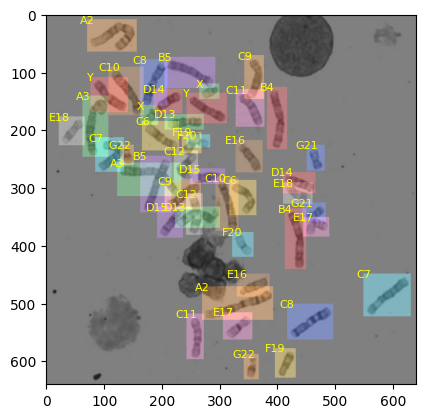

In [4]:
# Render the first training image with segmentation mask
# Get the first image ID
train_img_id = list(train_coco.imgs.keys())[0]

train_img_info = train_coco.loadImgs(train_img_id)[0]
train_img = cv2.imread(os.path.join(train_path, train_img_info["file_name"]))

train_ann_ids = train_coco.getAnnIds(imgIds=train_img_id)
train_anns = train_coco.loadAnns(train_ann_ids)


def show_annotations(anns, img):
    """
    Show segmentation masks of individual chromosomes on a given karyotype image

    Args:
        anns: list of annotations
        img: image to show annotations on
    """
    masks = [train_coco.annToMask(ann) for ann in anns]

    # Create a new image with the same dimensions as the original image
    mask_image = np.zeros_like(img)

    # Overlay the masks on the original image
    for i, mask in enumerate(masks):
        # apply mask to the image with color
        color = CLASS_COLORS[anns[i]["category_id"]]
        mask_3channel = np.zeros_like(img)
        for c in range(3):
            mask_3channel[:, :, c] = mask * color[c] * 255
        mask_image = cv2.addWeighted(mask_image, 1.0, mask_3channel, 0.5, 0)

    plt.imshow(img)
    plt.imshow(mask_image, alpha=0.5)
    # Add labels for each chromosome using class_names to the masks
    for i, mask in enumerate(masks):
        # Get bbox coordinates and dimensions
        x = anns[i]["bbox"][0]
        y = anns[i]["bbox"][1]

        label = f"{CLASS_NAMES[anns[i]['category_id']]}"
        plt.text(x, y, label, fontsize=8, color='yellow', ha='center', va='center')

    plt.show()

show_annotations(train_anns, train_img)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1462.0ms
Speed: 3.6ms preprocess, 1462.0ms inference, 9.4ms postprocess per image at shape (1, 3, 1024, 1024)


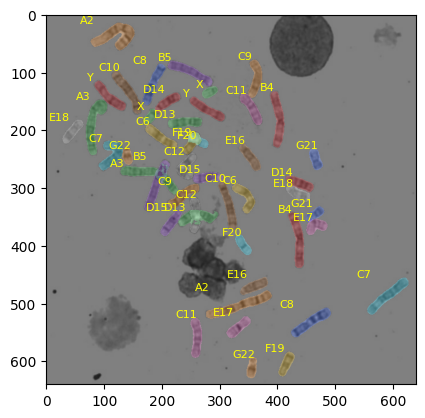

In [44]:
# Get the first image ID
train_img_id = list(train_coco.imgs.keys())[0]

train_img_info = train_coco.loadImgs(train_img_id)[0]
train_img = cv2.imread(os.path.join(train_path, train_img_info["file_name"]))

train_ann_ids = train_coco.getAnnIds(imgIds=train_img_id)
train_anns = train_coco.loadAnns(train_ann_ids)

# Feed boxes to SAM
model = SAM("sam2.1_b.pt")


anns = train_anns
bboxes = [ann["bbox"] for ann in anns]
labels = [ann["category_id"] for ann in anns]
names = [CLASS_NAMES[label] for label in labels]
# convert bbox to xyxy expected by SAM
bboxes = [[bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]] for bbox in bboxes]

results = model(train_img, bboxes=bboxes, labels=labels)
mask_data = results[0].masks
masks = [list(mask.data) for mask in mask_data]

def plot_segmented_chromosomes(base_img, masks, bboxes, labels, names = None):
    """
    Plot the segmented chromosomes on the original image

    Args:
        base_img: the original image
        masks: the segmentation masks
        bboxes: the bounding boxes of the chromosomes
        labels: the class labels of the chromosomes
        names: (optional) the names of the chromosomes to display on the masks
    """
    # plot the original image
    plt.imshow(base_img)
    # Create a new image with the same dimensions as the original image
    mask_image = np.zeros_like(base_img)
    # Overlay the masks on the original image
    for i, mask in enumerate(masks):
        # apply mask to the image with color
        color = CLASS_COLORS[labels[i]]  # Use i instead of 0 to get correct color
        mask_3channel = np.zeros_like(base_img)
        for c in range(3):
            mask_3channel[:, :, c] = mask[0] * color[c] * 255  # Use mask[0] to get first mask
        mask_image = cv2.addWeighted(mask_image, 1.0, mask_3channel, 0.5, 0)

    plt.imshow(mask_image, alpha=0.5)

    if names is not None:
        # Add labels for each chromosome using class_names to the masks
        for i, mask in enumerate(masks):
            # Get bbox coordinates and dimensions
            x = bboxes[i][0]
            y = bboxes[i][1]

            label = f"{names[i]}"
            plt.text(x, y, label, fontsize=8, color='yellow', ha='center', va='center')

    plt.show()
    
plot_segmented_chromosomes(train_img, masks, bboxes, labels, names)


In [95]:
# Helper function to display images
def display_image_grid(images, labels, nrows=None, ncols=None, labels_below=False):
    """
    Displays a grid of images as square as possible,
    or as specified by nrows and ncols.

    Args:
        images: A list of images (e.g., NumPy arrays).
        labels: A list of labels (e.g., strings).
        nrows: Number of rows in the grid.
        ncols: Number of columns in the grid.
        labels_below: If True, labels are displayed below the images.
    """
    if nrows is None:
        nrows = int(np.ceil(np.sqrt(len(images))))
    if ncols is None:
        ncols = int(np.ceil(len(images) / nrows))

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            if labels_below:
                # anchor to the bottom for alignment of heterogenous image sizes
                ax.set_anchor("S")
                ax.set_title(labels[i], y=-0.2)
            else:
                # anchor to the top for alignment of heterogenous image sizes
                ax.set_anchor("N")
                ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    return fig

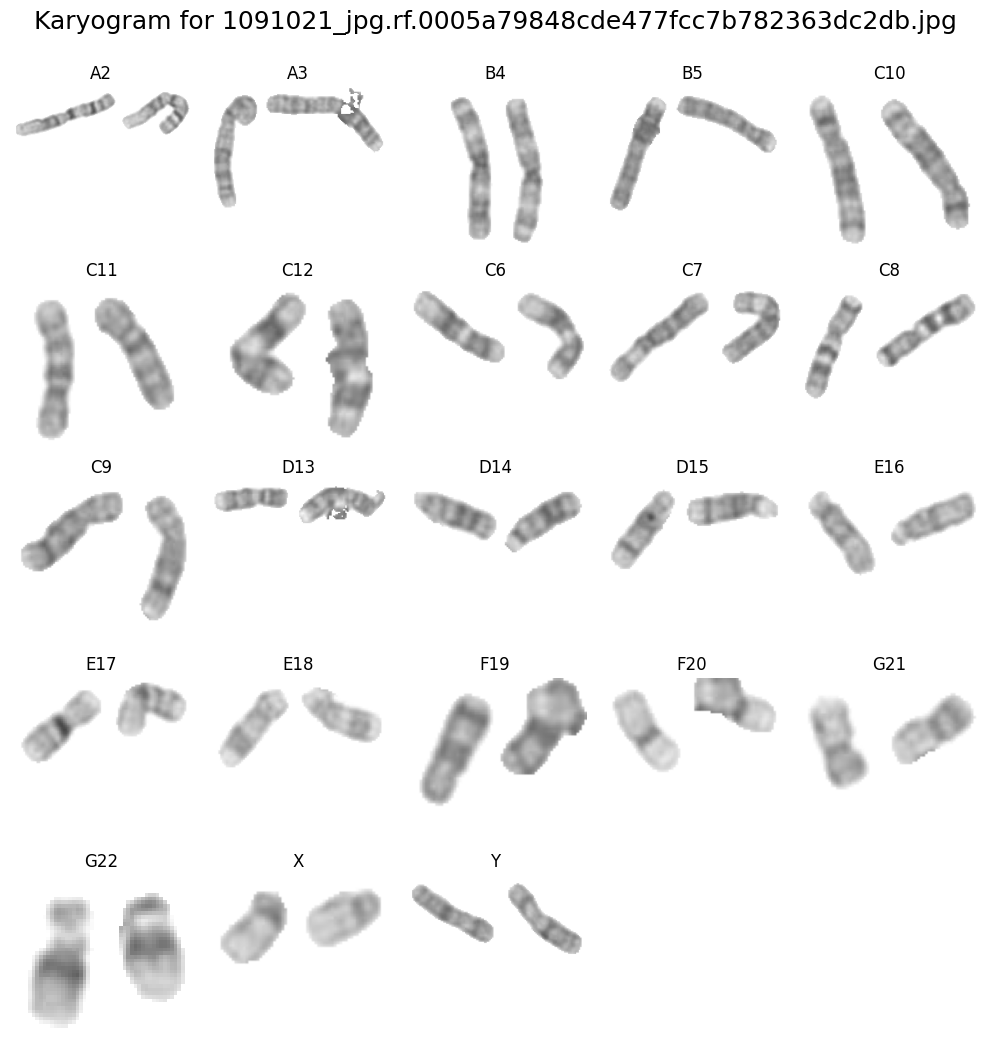

In [138]:
# Extract separate images for each chromosome
chrom_images = []
chrom_segmentations = []
for i, mask in enumerate(masks):
    bbox = bboxes[i]
    segmentation_polygons = results[0].masks[i].xy
    # create a copy of the original image
    chrom_img = train_img.copy()
    # remove everything but the masked area
    chrom_img = chrom_img * np.repeat(mask, 3, axis=0).transpose(1, 2, 0) + 255 * (
        1 - np.repeat(mask, 3, axis=0).transpose(1, 2, 0)
    )
    # extract a cropped image of the chromosome
    chrom_img = chrom_img[bbox[1] : bbox[3], bbox[0] : bbox[2]]
    # transform the segmentation polygons to matched the cropped chrom_img
    segmentation_polygons = [polygon - np.array([bbox[0], bbox[1]]) for polygon in segmentation_polygons]
    # save the image
    chrom_images.append(chrom_img)
    chrom_segmentations.append(segmentation_polygons)
# group the chromosomes by class and plot them side by side
chromosomes = list(zip(names, chrom_images))

# Sort the data by the key (first element of each tuple)
chromosomes.sort(key=lambda x: x[0])

# Group the data by the key and collect all groups
grouped_chromosomes = []
for key, group in groupby(chromosomes, key=lambda x: x[0]):
    grouped_chromosomes.append((key, list(group)))

# Create new side-by-side images for each chromosome type
side_by_side_images = []
for key, group in grouped_chromosomes:
    # plot the images of the same chromosome types side by side
    images = [chrom_img for _, chrom_img in list(group)]

    # find max height and width
    max_height = max(img.shape[0] for img in images)

    # pad images to same height
    padded_images = []
    for img in images:
        if img.shape[0] < max_height:
            pad_height = max_height - img.shape[0]
            padded_img = np.pad(
                img,
                ((0, pad_height), (0, 0), (0, 0)),
                mode="constant",
                constant_values=255,
            )
            padded_images.append(padded_img)
        else:
            padded_images.append(img)

    # create a new image with padded images side by side
    new_image = np.concatenate(padded_images, axis=1)
    side_by_side_images.append(new_image)

side_by_side_labels = [key for key, _ in grouped_chromosomes]
karyogram = display_image_grid(
    side_by_side_images, side_by_side_labels
)
karyogram.suptitle(f"Karyogram for {train_img_info['file_name']}", y=1.04, fontsize=18)
karyogram.savefig("karyogram.png")

In [ ]:
# model = YOLO("weights/yolo11s.pt")

# first_bbox = train_anns[0]["bbox"]
# results = model(train_img)
# results[0].masks.data


# get polygons

# train for instance segmentation
